In [1]:
import os
import nibabel as nib
from scipy import ndimage
import numpy as np
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Data Pre-Processing

Here we define several helper functions to process the data. These functions will be used when building training and validation datasets.

In [3]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

# CT scans store raw voxel intensity in Hounsfield units (HU). 
# Above 400 are bones with different radiointensity, so this is used as a higher bound. 
# A threshold between -1000 and 400 is commonly used to normalize CT scans.


def normalize(volume):
    """Normalize the volume"""
    print('Normalizing started')
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    print('Normalizing ended')
    return volume

# To process the data, we do the following:

# 1)We first rotate the volumes by 90 degrees, so the orientation is fixed
# 2)We scale the HU values to be between 0 and 1.
# 3)Downsample the scans to have shape of 128x128x64..

def resize_volume(img):
    """Resize across z-axis"""
    print('resizing started')
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    print('resizing completed')
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    print(f'processing: {path}')
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


## Reading the data

In [4]:
# Folder "CT-0" consist of CT scans having non recurrence lung cancer
norecurrent_scan_paths = [
    os.path.join(os.getcwd(), "DataMos/CT-0", x)
    for x in os.listdir("DataMos/CT-0")
]
# Folder "CT-1" consist of CT scans having history of recurrence lung cancer
recurrent_scan_paths = [
    os.path.join(os.getcwd(), "DataMos/CT-1", x)
    for x in os.listdir("DataMos/CT-1")
]

print("CT scans with non-recurrent(CT-0) lung tissue: " + str(len(norecurrent_scan_paths)))
print("CT scans with recurrent(CT-1) lung tissue: " + str(len(recurrent_scan_paths)))

CT scans with non-recurrent(CT-0) lung tissue: 156
CT scans with recurrent(CT-1) lung tissue: 54


## Data Pre-processing and Storing
Use it only once. This process takes time, because it actually changes every CT scan image of every patient
as per the pre-processing pipeline established above

In [ ]:
# Use only once
# # Read and process the scans.
# # Each scan is resized across height, width, and depth and rescaled.
# norecurrent_scans = np.array([process_scan(path) for path in norecurrent_scan_paths])
# np.save('norecurrent_scans', norecurrent_scans.astype(np.float32))
# recurrent_scans = np.array([process_scan(path) for path in recurrent_scan_paths])
# np.save('recurrent_scans', recurrent_scans.astype(np.float32))

## Loading the pre-processed Data

In [5]:
# Use everytime kernal crashes

recurrent_scans = np.load('/user/gr1/delphi/tsaha/code/recurrent_scans.npy').astype(np.float32)
norecurrent_scans = np.load('/user/gr1/delphi/tsaha/code/norecurrent_scans.npy').astype(np.float32)

## Loading the labels
For the sake of simplicity, we label the CT scans of recurrent patients as 1 and we label the CT scans of
non-recurrent patients as 0

In [6]:
# For the CT scans having recurrent lang cancer
# assign 1, for the non recurrent ones assign 0.
recurrent_labels = np.array([1 for _ in range(len(recurrent_scans))])
norecurrent_labels = np.array([0 for _ in range(len(norecurrent_scans))])

## Data Augmentation

Balancing the dataset

In [7]:
## Helper function

def augment_image(volume):
    # Convert to SimpleITK image
    sitk_image = sitk.GetImageFromArray(volume)

    # Define a SimpleITK Transform
    transform = sitk.AffineTransform(3)
    transform.Scale((1.1, 1.1, 1.1))  # Scaling

    # Apply the transform to the image
    augmented_sitk_image = sitk.Resample(sitk_image, transform)

    # Convert back to numpy array
    augmented_volume = sitk.GetArrayFromImage(augmented_sitk_image)

    return augmented_volume

In [8]:
target_size = len(norecurrent_scans)
augmented_recurrent_scans = []

while len(augmented_recurrent_scans) < target_size:
    # Randomly choosing an original scan from recurrent_scans
    original_scan = recurrent_scans[np.random.randint(len(recurrent_scans))]

    # Appling the data augmentation, helper class function defined above
    augmented_scan = augment_image(original_scan)

    # Appending to the list of augmented images
    augmented_recurrent_scans.append(augmented_scan)

# Converting the list of augmented images to a numpy array
augmented_recurrent_scans = np.stack(augmented_recurrent_scans, axis=0)

## Printing the classwise Balanced Dataset

In [9]:
print("Shape of augmented recurrent_scans:", augmented_recurrent_scans.shape)
print("Shape of non - recurrent_scans:", norecurrent_scans.shape)
print("Total scans:", augmented_recurrent_scans.shape[0] + norecurrent_scans.shape[0])

Shape of augmented recurrent_scans: (156, 128, 128, 64)
Shape of non - recurrent_scans: (156, 128, 128, 64)
Total scans: 312


## Augmenting the less reprented labels as well

In [10]:
num_tiles = target_size // len(recurrent_labels) + 1
augmented_recurrent_labels = np.tile(recurrent_labels, num_tiles)[:target_size]

## Splitting the dataset into Train, Test and Validate sets

In total, after data balancing has been performed using Data Augmentation, we now have both clases represented with 156 CT scans each, making a total of 312 scans. 

We first take 70% of this data, which comes around 220 and use it for training. 

From the remaining data, we use 64 for validation during the train epochs. 

While the left over 28 data, which is completely new and unseen to the model will be used for testing the performance of the model.

In [11]:
x_train = np.concatenate((augmented_recurrent_scans[:110], norecurrent_scans[:110]), axis=0)
y_train = np.concatenate((augmented_recurrent_labels[:110], norecurrent_labels[:110]), axis=0)
x_val = np.concatenate((augmented_recurrent_scans[110:], norecurrent_scans[110:]), axis=0)
y_val = np.concatenate((augmented_recurrent_labels[110:], norecurrent_labels[110:]), axis=0)

x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.30, random_state=0)

print(
    "Number of samples in train, validation and test are %d, %d and %d."
    % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
)

Number of samples in train, validation and test are 220, 64 and 28.


## DataLoaders

In [12]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 5
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

## Data Visualization

Dimension of the CT scan is: (128, 128, 64)


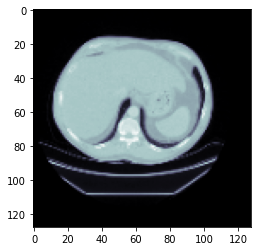

In [13]:
data = train_dataset.take(20)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 13]), cmap="bone")

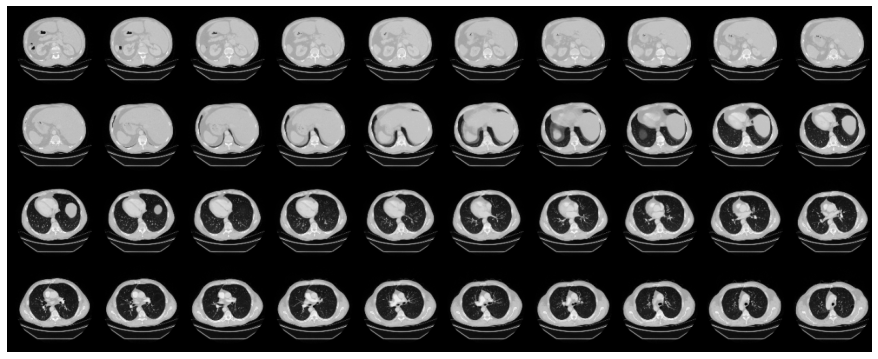

In [14]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## 3D Convolution Neural Network

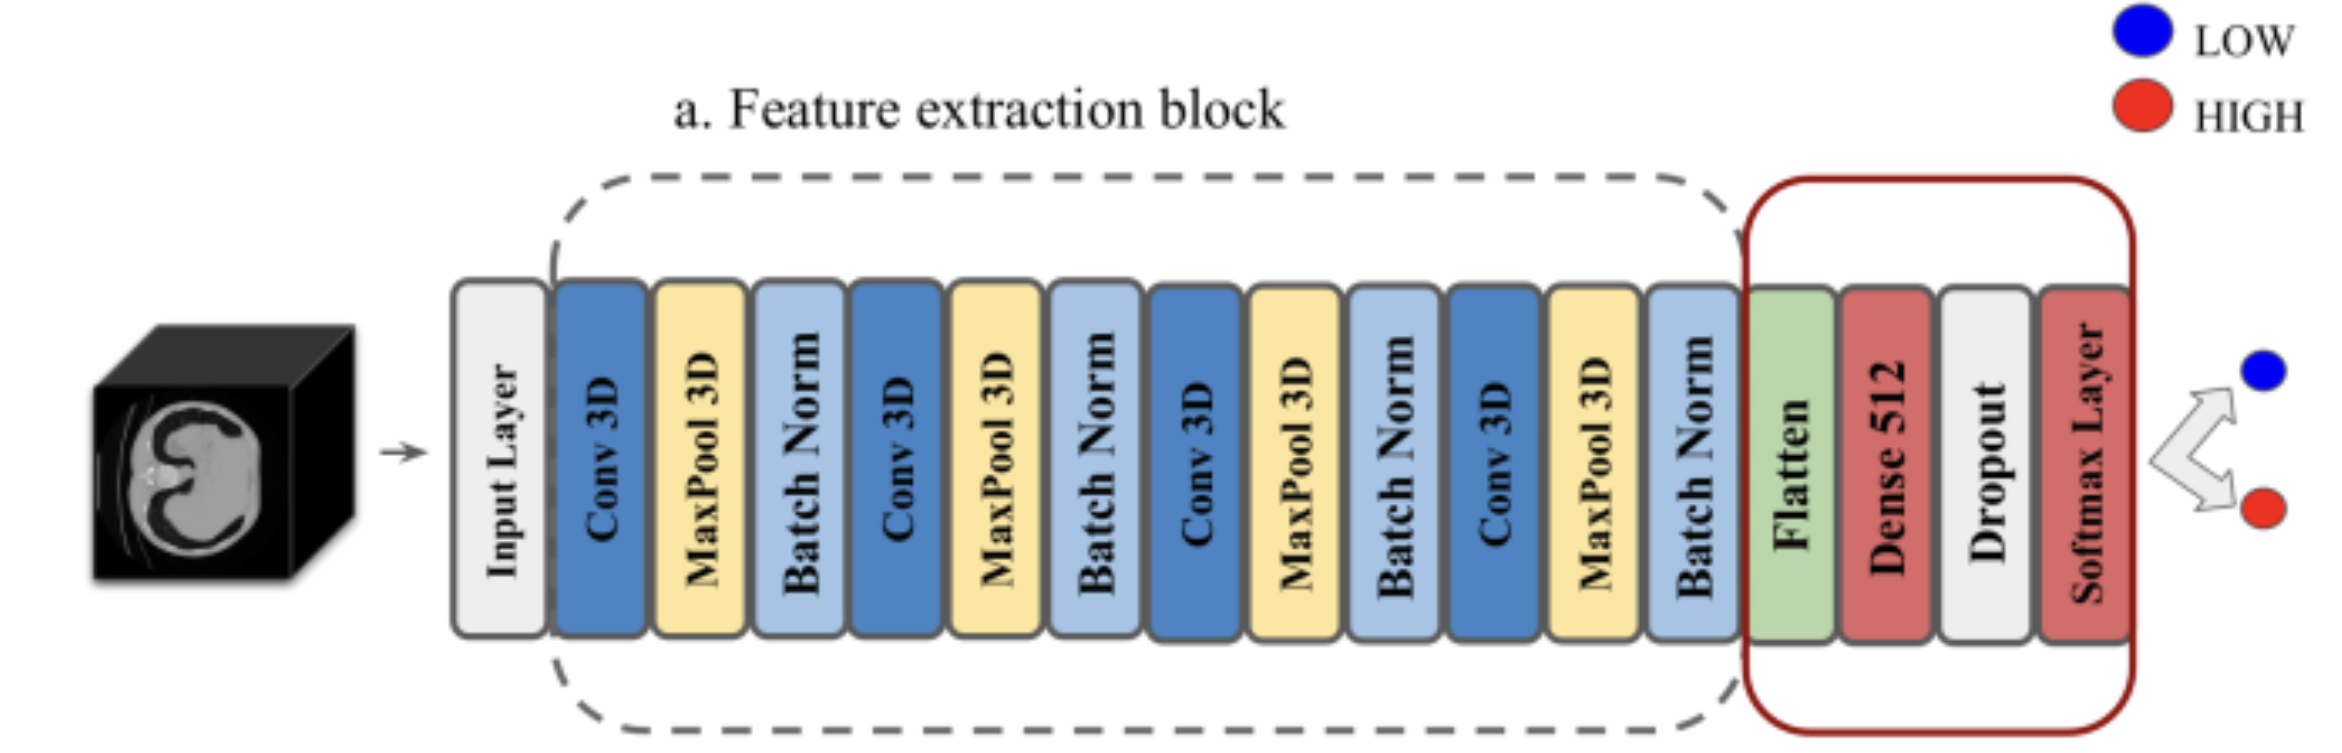


In [15]:
def tatz3DCNN(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = tatz3DCNN(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

## Load previous weights if any

Run this cell if the trains stops for any unforceen circumstances. 

resumed_epochs = Replace with the epoch you want to resume from. For the 1st time run, make it 0

Load the previous weights, so that model can start with the previous training data. For the 1st time training, DO NOT RUN THIS LINE AT ALL.

In [16]:
resumed_epochs = 18 
model = load_model("my3DCNN.keras")

## Model Training

In [ ]:
# Compile model.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "my3DCNN.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100

model.fit(train_dataset,
    validation_data=validation_dataset,
    epochs=epochs - resumed_epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],)

print("Training Completed Successfully!!")

## Training/Validation progress visualization

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Performance Testing

In [16]:
threshold = 0.5

def getPredictedClass (index):
    # Load best weights.
    model.load_weights("my3DCNN.keras")
    prediction = model.predict(np.expand_dims(x_test[index], axis=0))[0]
    scores = [1 - prediction[0], prediction[0]]
    print(f'scores is {scores}')
    predictedClass = 0

    if (scores[0] > threshold) :
        predictedClass = 0
    elif (scores[1] > threshold):
        predictedClass = 1
    return predictedClass

Get the predicted class for all the unseen test data

In [ ]:
prediction = []
for i in range(x_test.shape[0]):
    prediction.append(getPredictedClass(i))

## Confusion Matrix

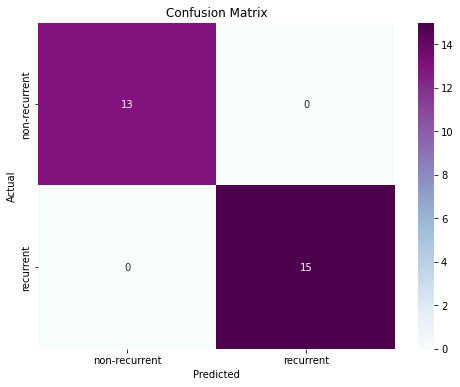

In [34]:
# Plot the confusion matrix
y_true = np.array(y_test)
y_pred =  np.array(prediction)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
labelz = np.unique(y_true)
# Mapping dictionary
mapping_dict = {0: "non-recurrent", 1: "recurrent"}
# vectorized function
vectorized_function = np.vectorize(lambda x: mapping_dict[x])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=vectorized_function(labelz), 
    yticklabels=vectorized_function(labelz))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()